1. CAS Requests Dataset
2. Test Setup & Persistence Model Forecast
4. LSTM Data Preparation
5. LSTM Model Development
6. LSTM Forecast
7. Complete LSTM Example
8. Develop a Robust Result

# CAS Requests Dataset

In [47]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [48]:
# load the dataset 

df = pd.read_csv("Data_final.csv",parse_dates=[0],index_col=0)
# first few rows

df.head()

,Requests
Date,
1998-01-01,137317594
1998-02-01,133211380
1998-03-01,149453070
1998-04-01,148053372
1998-05-01,153271739


In [49]:
df.tail(8)

,Requests
Date,
2018-01-01,701676279
2018-02-01,674027650
2018-03-01,758219563
2018-04-01,729014682
2018-05-01,771300508
2018-06-01,753250664
2018-07-01,749102384
2018-08-01,779623151


In [50]:
df.shape

(248, 1)

We have total 248 observations and 19 years starting from 1998 and 2017 years.

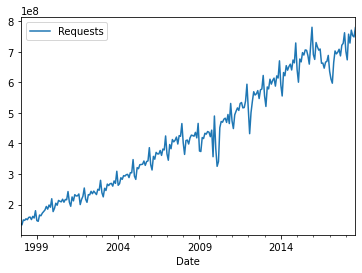

In [51]:
df.plot()
plt.show()

A line plot of the series is then created showing a clear increasing trend.

# Test Setup & Persistence model

In [52]:
# split data into train and test
X = df.values
train, test = X[0:-48], X[-48:]

In [53]:
train.shape

(200, 1)

In [54]:
test.shape

(48, 1)

In [55]:
history = [x for x in train]
predictions = list()

In [56]:
len(history)

200

In [57]:
for i in range(len(test)):
  predictions.append(history[-1])
  history.append(test[i]) 

In [58]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 39166981.527


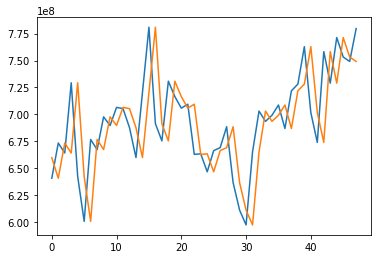

In [59]:
# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions)
plt.show()

Now that we have a baseline of performance on the dataset, we can get started developing an LSTM model for the data.

# LSTM Data Preparation

### Transform Time Series to Supervised Learning

In [68]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [69]:
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

             0          0
0          0.0  137317594
1  137317594.0  133211380
2  133211380.0  149453070
3  149453070.0  148053372
4  148053372.0  153271739


### Transform Time Series to Stationary

In [72]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [74]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [75]:
# transform to be stationary
differenced = difference(X, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(X, differenced[i], len(X)-i)
	inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0    [-4106214]
1    [16241690]
2    [-1399698]
3     [5218367]
4    [-2941252]
dtype: object
0    [133211380]
1    [149453070]
2    [148053372]
3    [153271739]
4    [150330487]
dtype: object


### Transform Time Series to Scale

In [76]:
from sklearn.preprocessing import MinMaxScaler

In [79]:
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

0   -0.987319
1   -1.000000
2   -0.949843
3   -0.954166
4   -0.938051
dtype: float64
0    137317594.0
1    133211380.0
2    149453070.0
3    148053372.0
4    153271739.0
dtype: float64


# LSTM Model Development

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

In [2]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [3]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [4]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [6]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [7]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [8]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [9]:
# load dataset
series = read_csv('Data_final.csv', header=0, parse_dates=[0], index_col=0)

In [10]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [11]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [12]:
# split data into train and test-sets
train, test = supervised_values[0:-48], supervised_values[-48:]

In [13]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [14]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100,1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.29780954],
       [-0.23030382],
       [-0.22034031],
       [-0.1481851 ],
       [-0.12500362],
       [-0.06807205],
       [-0.07816666],
       [-0.04471135],
       [ 0.01832959],
       [-0.04260278],
       [ 0.01897204],
       [-0.10483691],
       [ 0.09849924],
       [ 0.04744831],
       [-0.07304341],
       [-0.00523809],
       [-0.03716874],
       [-0.03157255],
       [-0.03150505],
       [-0.06139195],
       [ 0.02287197],
       [-0.05479306],
       [ 0.02201644],
       [-0.12324034],
       [ 0.11370364],
       [-0.02299339],
       [-0.08279029],
       [ 0.00286803],
       [-0.07501021],
       [-0.01219931],
       [ 0.00834441],
       [-0.03094551],
       [ 0.04749924],
       [-0.01702508],
       [ 0.01441598],
       [-0.11636168],
       [ 0.09953588],
       [ 0.10442451],
       [-0.10730833],
       [ 0.02580386],
       [-0.09118539],
       [-0.01267546],
       [-0.00586987],
       [-0.02455086],
       [ 0.16345304],
       [-0

In [15]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=659956045.668223, Expected=640821924.000000
Month=2, Predicted=655782157.851693, Expected=673482961.000000
Month=3, Predicted=667610524.668429, Expected=664210069.000000
Month=4, Predicted=672592297.990292, Expected=729341188.000000
Month=5, Predicted=709660845.099384, Expected=642349544.000000
Month=6, Predicted=640135430.453838, Expected=600791593.000000
Month=7, Predicted=609421628.435714, Expected=676741732.000000
Month=8, Predicted=653178590.496278, Expected=667388171.000000
Month=9, Predicted=658437088.248811, Expected=697729874.000000
Month=10, Predicted=682892446.194813, Expected=689745068.000000
Month=11, Predicted=687378552.686322, Expected=706532899.000000
Month=12, Predicted=700559627.570398, Expected=705389917.000000
Month=13, Predicted=707594288.626840, Expected=687697347.000000
Month=14, Predicted=702630384.107700, Expected=659993840.000000
Month=15, Predicted=688676650.859678, Expected=720272108.000000
Month=16, Predicted=705903764.206555, Expected=78

Test RMSE: 36614038.636


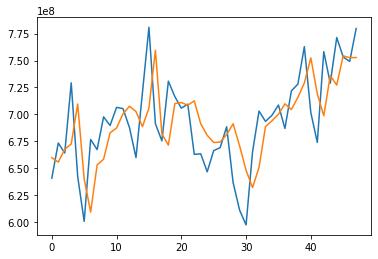

In [18]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-48:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-48:])
pyplot.plot(predictions)
pyplot.show()